In [24]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date

import file

In [25]:
# Define the ticker symbol
tickerSymbol = 'QQQ'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())

In [27]:
gap = 0

option_leverage = file.load_all_option_leverage()[tickerSymbol]

In [28]:
max_weeks = 52
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.mean()  * 52 / weeks) # annualized

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        positive_percent = (option_profits > 0).mean() * 100
        option_performance.append([weeks, mean_profit, positive_percent])
        history[f'Option {weeks}w'] = option_profits # ? * 52 / weeks # annualized

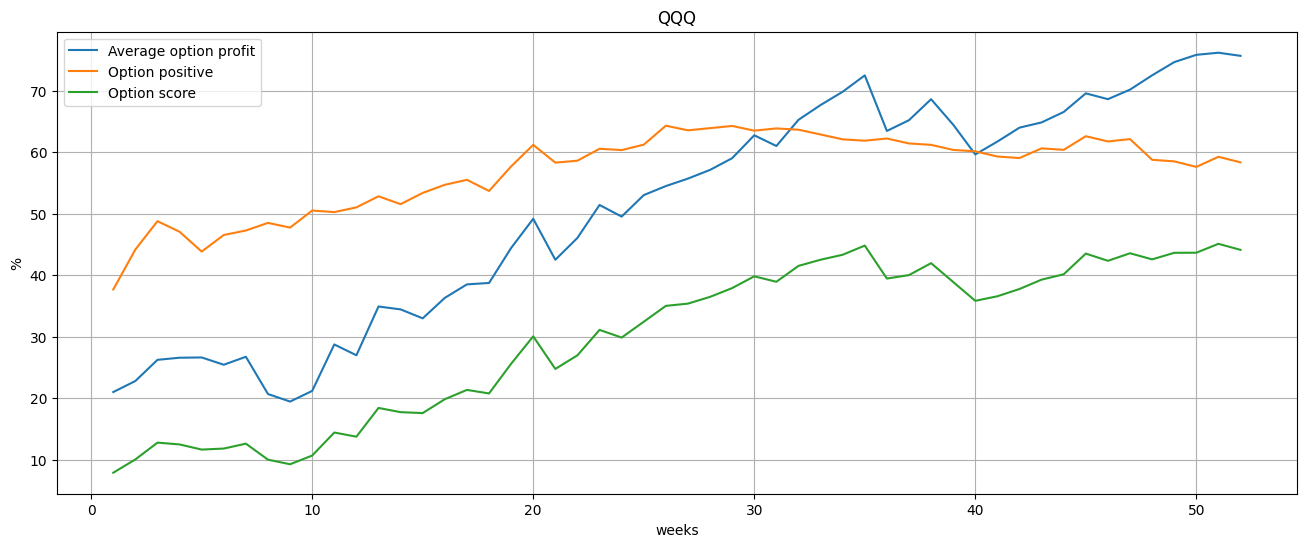

In [31]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit')
plt.plot(option_weeks, option_positive, label='Option positive')
plt.plot(option_weeks, option_score, label='Option score')
plt.legend(loc='upper left')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

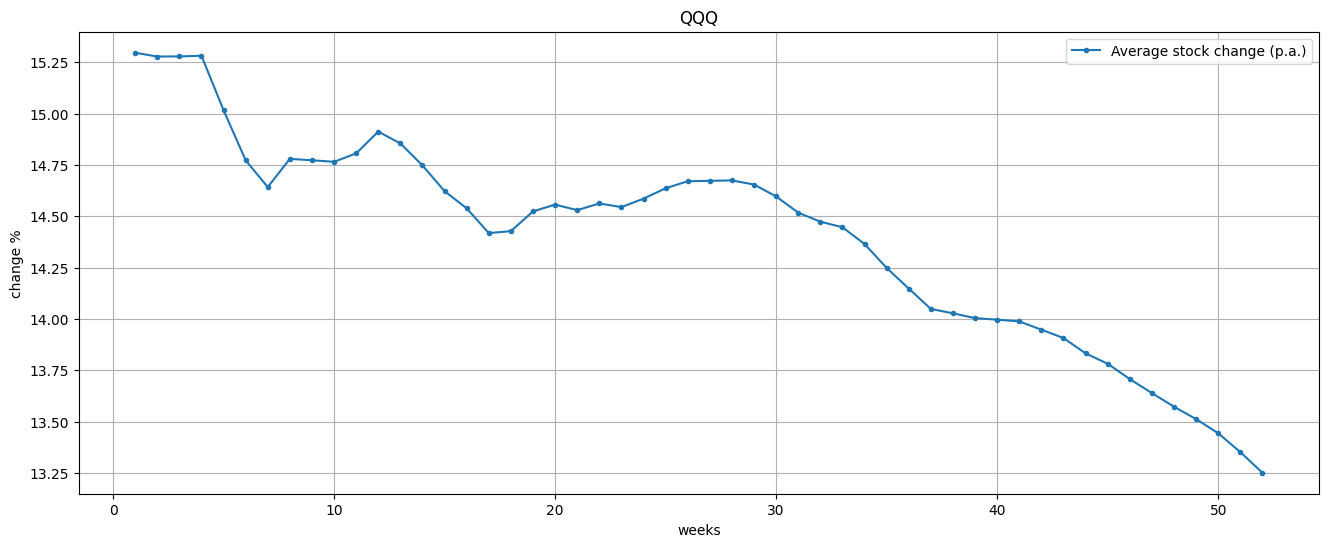

In [32]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Average stock change (p.a.)', marker='.')
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


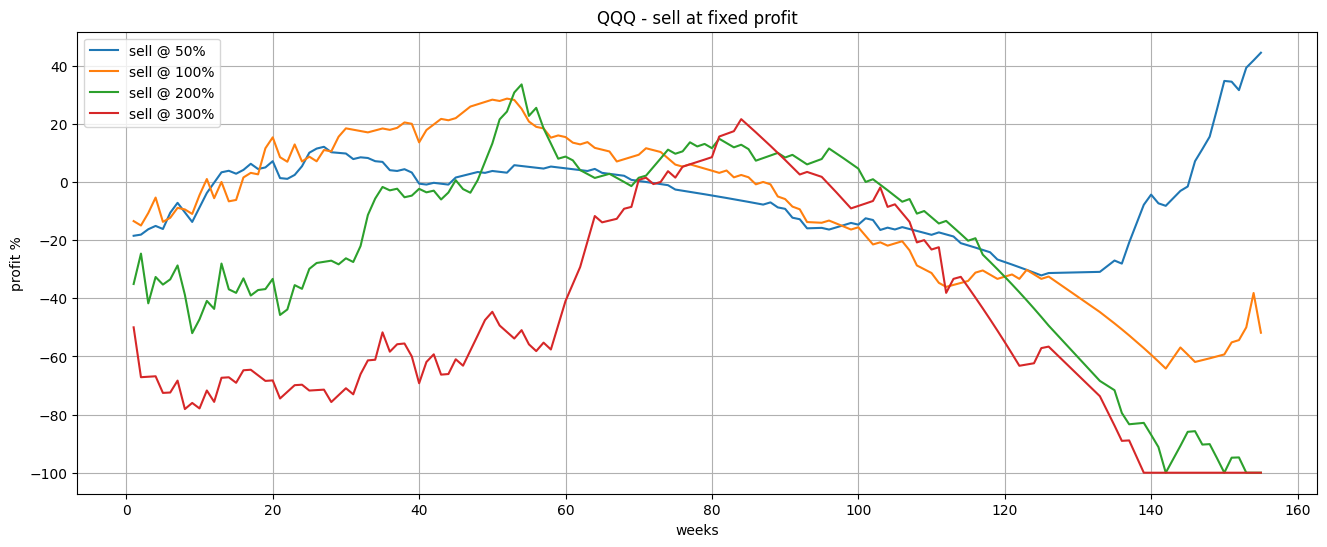

In [35]:
plt.figure(figsize=(16,6))

for percent in [50,100,200,300]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax = wmax.dropna()
        q = (wmax >= percent).mean()
        data[weeks] = q * (percent + 100) - 100

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - sell at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

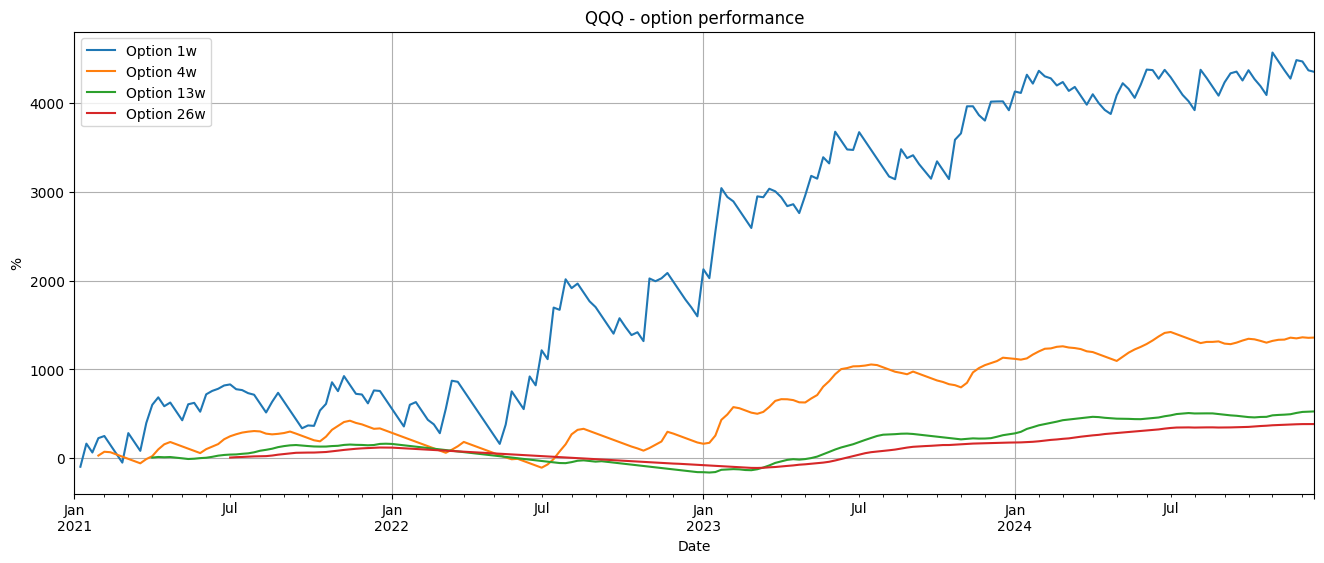

In [40]:
plt.figure(figsize=(16,6))

for w in [1,4,13,26]:
    (history[f'Option {w}w']/w).cumsum().plot()

plt.legend()
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('%')
# plt.yscale('log')
plt.grid()
plt.show()
